## 1. Configurations (Imports & Hyperparameters)

In [1]:
import os
import random
import json
import glob
import numpy as np
import pandas as pd                             
import torch
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Hyperparameters
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 42

# Reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


## 2. Load labels exported from LabelBox

In [ ]:
NDJSON_PATH = 'labels.ndjson'
IMG_DIR = "ALL_SPLIT_IMAGES"
label_columns = [
    "Open Water",
    "Floating Vegetation",
    "Reedlands & Permanent Swamps",
    "Tall Seasonal Sedge Wetlands",
    "Short Seasonal Grass Floodplains",
    "Riparian Forest",
    "Woodlands",
    "Bare Ground / Dry Grass",
    "Shrubland", 
    "[Lvl 2] Water Lily",
    "[Lvl 2] Rafts",
    "[Lvl 2] Salvinia / Other Fern",
    "[Lvl 2] Papyrus",
    "[Lvl 2] Phragmites / Miscanthus"
]

records = []
with open(NDJSON_PATH, "r") as file:
    for line in file:
        record = json.loads(line)
        external_id = record["data_row"]["external_id"]

        # start a new flattened row with all labels initialized to NaN
        row_dict = {"external_id": external_id}
        for label in label_columns:
            row_dict[label] = np.nan
        # Fill from the accepted "selected_label_id" block only in each project (due to 2 labelers setting)
        for project_data in record.get("projects", {}).values():
            labels_list = project_data.get("labels", [])
            # When multiple labelers and need to select the chosen one.
            sel_id = project_data.get("project_details", {}).get("selected_label_id", None)
            if sel_id:
                labels_to_parse = [lbl for lbl in labels_list if lbl["id"] == sel_id] # find the one matching that id
            else:
                labels_to_parse = labels_list # no selected_label_id, just parse everything
            for selected_label_data in labels_to_parse:
                for classification in selected_label_data.get("annotations", {}).get("classifications", []):
                    name = classification["name"]
                    if name not in label_columns:
                        continue
                    # radio
                    elif classification.get("radio_answer"):
                        row_dict[name] = classification["radio_answer"]["name"]
                    # fallback
                    else:
                        row_dict[name] = classification.get("value")
        records.append(row_dict)
df_all = pd.DataFrame(records) # Convert collected records from ndjson to df

nonlabel_columns = {"external_id"}
label_columns = [col for col in df_all.columns if col not in nonlabel_columns]
print(f"Updated label_columns: {label_columns}")
print(f"Number of label columns: {len(label_columns)}")
print(f"Number of rows: {len(df_all)}")
pd.set_option('display.max_columns', 100) 
df_all.head(200)

Updated label_columns: ['Open Water', 'Floating Vegetation', 'Reedlands & Permanent Swamps', 'Tall Seasonal Sedge Wetlands', 'Short Seasonal Grass Floodplains', 'Riparian Forest', 'Woodlands', 'Bare Ground / Dry Grass', 'Shrubland', '[Lvl 2] Water Lily', '[Lvl 2] Rafts', '[Lvl 2] Salvinia / Other Fern', '[Lvl 2] Papyrus', '[Lvl 2] Phragmites / Miscanthus']
Number of label columns: 14
Number of rows: 1558


,external_id,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IMG_20230729_092645_00_104_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IMG_20230729_092645_00_109_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IMG_20230729_092645_00_201_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IMG_20230729_092645_00_218_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMG_20230819_084913_00_448_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Likely
196,IMG_20230803_115240_00_543_right.jpg,NaN,NaN,2 - Likely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 - Definitely
197,IMG_20230815_081054_00_665_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,IMG_20230802_085359_00_491_right.jpg,NaN,NaN,NaN,NaN,1 - Definitely,NaN,NaN,NaN,NaN,NaN,1 - Definitely,NaN,NaN,NaN


## 3. Clean rows w/ no labels at all

In [ ]:
# Check rows where label columns are NaN
nan_mask = df_all[label_columns].isna().all(axis=1)
df_no_labels = df_all[nan_mask].reset_index(drop=True)

print(f"Found {len(df_no_labels)} rows with no labels at all.")
df_no_labels.head()   


Found 0 rows with no labels at all.


,external_id,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus


In [4]:
df_all = (df_all.dropna(subset=label_columns, how="all").reset_index(drop=True))
print(f"Remaining rows after dropping images with no labels: {len(df_all)}")
df_all.head()

Remaining rows after dropping images with no labels: 1558


,external_id,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IMG_20230729_092645_00_104_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IMG_20230729_092645_00_109_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IMG_20230729_092645_00_201_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IMG_20230729_092645_00_218_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Sanity Check for _left/_right pairs

In [5]:
# Check for stray images WITHOUT "_left.jpg" or "_right.jpg" using mask
plain_mask = ~df_all["external_id"].str.endswith(("_left.jpg", "_right.jpg", "_left_okw.jpg", "_right_okw.jpg"))
df_plain = df_all.loc[plain_mask].reset_index(drop=True) # new df of stray images
print(f"{len(df_plain)} images without a left/right suffix")
df_plain.head(200)


0 images without a left/right suffix


,external_id,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus


In [6]:
# Update df so we select only rows with _left _right halves
mask = df_all['external_id'].str.endswith(("_left.jpg","_right.jpg"))
df_all = df_all[mask].reset_index(drop=True)
print(f"Number of rows: {len(df_all)}")

df_all.head()


Number of rows: 1558


,external_id,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IMG_20230729_092645_00_104_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IMG_20230729_092645_00_109_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IMG_20230729_092645_00_201_left.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IMG_20230729_092645_00_218_right.jpg,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Attach image paths to images

In [7]:
def create_img_path_mapping(root_directory):
    jpeg_paths = glob.glob(os.path.join(root_directory, "**", "*.jpg"), recursive=True)
    mapping = {}
    for full_path in jpeg_paths:
        fn = os.path.basename(full_path)
        mapping[fn] = full_path
    return mapping

path_map = create_img_path_mapping(IMG_DIR)
image_path_series = df_all["external_id"].map(path_map)

df_all.insert(1, "image_path", image_path_series)

print(f"Number of rows: {len(df_all)}")

df_all = df_all.drop(columns=[c for c in nonlabel_columns if c in df_all.columns and c != "external_id"])

df_all.head()

Number of rows: 1558


,external_id,image_path,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_101_ri...,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IMG_20230729_092645_00_104_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_104_ri...,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IMG_20230729_092645_00_109_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_109_le...,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IMG_20230729_092645_00_201_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_201_le...,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IMG_20230729_092645_00_218_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_218_ri...,1 - Definitely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check how many rows that failed to get path mapping
missing = df_all["image_path"].isna().sum()
print(f"{missing} rows have no matching image_path")

# Check for unique path mappings to catch corner cases
print(f"{df_all['image_path'].nunique():,} unique paths mapped")

# If there are any misses, list them
if missing:
    print("Examples of unmatched filenames:")
    print(df_all.loc[df_all["image_path"].isna(), "external_id"].unique()[:10])


0 rows have no matching image_path
1,558 unique paths mapped


## 6. Convert all label responses to binary

In [9]:
df_binary = df_all.copy().fillna(0) # Make a binary copy with NaN turned to 0s
df_binary.head()

,external_id,image_path,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_101_ri...,1 - Definitely,0,0,0,0,0,0,0,0,0,0,0,0,0
1,IMG_20230729_092645_00_104_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_104_ri...,1 - Definitely,0,0,0,0,0,0,0,0,0,0,0,0,0
2,IMG_20230729_092645_00_109_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_109_le...,1 - Definitely,0,0,0,0,0,0,0,0,0,0,0,0,0
3,IMG_20230729_092645_00_201_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_201_le...,1 - Definitely,0,0,0,0,0,0,0,0,0,0,0,0,0
4,IMG_20230729_092645_00_218_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_218_ri...,1 - Definitely,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
POSITIVE_THRESHOLD = 2

def to_binary(entry):
    string = str(entry)
    parts = string.split()
    if parts and parts[0].isdigit(): # e.g. ["2", "-", "Likely"]
        num = int(parts[0])
        if (0 < num <= POSITIVE_THRESHOLD):
            return 1
        else:
            return 0 
    return 0 # catches 0, NaN, text, etc.

df_binary[label_columns] = df_binary[label_columns].map(to_binary)
df = df_binary.copy()
df.head()

,external_id,image_path,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_101_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,IMG_20230729_092645_00_104_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_104_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,IMG_20230729_092645_00_109_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_109_le...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,IMG_20230729_092645_00_201_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_201_le...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,IMG_20230729_092645_00_218_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_218_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## 7. Drop any labels with no positive cases

In [11]:
# Drop label columns that have no positive cases
label_sums = df[label_columns].sum(axis=0)
labels_to_drop = label_sums[label_sums == 0].index.tolist()
print(f"Labels with no positive cases: {labels_to_drop}")

# Update the dataframe and label_columns
df.drop(columns=labels_to_drop, inplace=True)
label_columns = [col for col in label_columns if col not in labels_to_drop]
print(f"Updated final label columns: {label_columns}")
print(f"Updated final number of label columns: {len(label_columns)}")
print(len(df))
df.head()

Labels with no positive cases: []
Updated final label columns: ['Open Water', 'Floating Vegetation', 'Reedlands & Permanent Swamps', 'Tall Seasonal Sedge Wetlands', 'Short Seasonal Grass Floodplains', 'Riparian Forest', 'Woodlands', 'Bare Ground / Dry Grass', 'Shrubland', '[Lvl 2] Water Lily', '[Lvl 2] Rafts', '[Lvl 2] Salvinia / Other Fern', '[Lvl 2] Papyrus', '[Lvl 2] Phragmites / Miscanthus']
Updated final number of label columns: 14
1558


,external_id,image_path,Open Water,Floating Vegetation,Reedlands & Permanent Swamps,Tall Seasonal Sedge Wetlands,Short Seasonal Grass Floodplains,Riparian Forest,Woodlands,Bare Ground / Dry Grass,Shrubland,[Lvl 2] Water Lily,[Lvl 2] Rafts,[Lvl 2] Salvinia / Other Fern,[Lvl 2] Papyrus,[Lvl 2] Phragmites / Miscanthus
0,IMG_20230729_092645_00_101_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_101_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,IMG_20230729_092645_00_104_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_104_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,IMG_20230729_092645_00_109_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_109_le...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,IMG_20230729_092645_00_201_left.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_201_le...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,IMG_20230729_092645_00_218_right.jpg,ALL_SPLIT_IMAGES\IMG_20230729_092645_00_218_ri...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def multilabel_stratified_split(
    df, 
    label_cols, 
    train_ratio, 
    val_ratio, 
    test_ratio, 
    random_state=RANDOM_SEED
):
    """
    Splits df into train/val/test by iterative (multilabel) stratification.
    train_ratio + val_ratio + test_ratio must sum to 1.0.
    Returns: df_train, df_val, df_test
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # First create subset for test set
    splitter1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)
    trainval_idx, test_idx = list(splitter1.split(df, df[label_cols].values))[0]
    df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
    df_test     = df.iloc[test_idx].reset_index(drop=True)
    
    # Then split train vs val from the remainder
    rel_val = val_ratio / (train_ratio + val_ratio)
    splitter2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=rel_val, random_state=random_state)
    train_idx, val_idx = list(splitter2.split(df_trainval, df_trainval[label_cols].values))[0]
    df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
    df_val   = df_trainval.iloc[val_idx].reset_index(drop=True)
    
    return df_train, df_val, df_test

def show_label_counts(df, label_columns, partition_name="Dataset"):
    """
    Prints the positive counts for each label in a given partition.
    """
    print(f"\nLabel positive counts in {partition_name}:")
    for label in label_columns:
        pos_count = df[label].sum()
        print(f"  {label:<40}: {int(pos_count)} occurrences")

def show_label_distribution(df, label_columns, partition_name="Dataset"):
    """
    Prints and plots the positive percentage for each label.
    """
    print(f"\nLabel distribution in {partition_name}:")
    positive_rates = {}
    for label in label_columns:
        pos_rate = df[label].mean() * 100
        positive_rates[label] = pos_rate
        print(f"  {label}: {pos_rate:.2f}% positive")
    plt.figure(figsize=(8,4))
    plt.bar(positive_rates.keys(), positive_rates.values())
    plt.ylabel("Positive (%)")
    plt.title(f"Label Distribution in {partition_name}")
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.show()

In [13]:
# Split train/val/test partitions & save to .csv
df_train, df_val, df_test = multilabel_stratified_split(
    df, 
    label_columns, 
    train_ratio=TRAIN_RATIO, 
    val_ratio=VAL_RATIO, 
    test_ratio=TEST_RATIO, 
    random_state=RANDOM_SEED
)
df_train.to_csv("train_partition.csv", index=False)
df_val.to_csv("val_partition.csv", index=False)
df_test.to_csv("test_partition.csv", index=False)
print("Partitions saved to .csv files.")

Partitions saved to .csv files.


In [14]:
# Load partitions from .csv
df_train = pd.read_csv("train_partition.csv")
df_val   = pd.read_csv("val_partition.csv")
df_test  = pd.read_csv("test_partition.csv")
print("Partitions loaded from .csv files.")
# Check label distribution
show_label_counts(df, label_columns, partition_name="Original Dataset")
show_label_counts(df_train, label_columns, partition_name="Train")
show_label_counts(df_val, label_columns, partition_name="Validation")
show_label_counts(df_test, label_columns, partition_name="Test")


Partitions loaded from .csv files.

Label positive counts in Original Dataset:
  Open Water                              : 494 occurrences
  Floating Vegetation                     : 85 occurrences
  Reedlands & Permanent Swamps            : 319 occurrences
  Tall Seasonal Sedge Wetlands            : 211 occurrences
  Short Seasonal Grass Floodplains        : 345 occurrences
  Riparian Forest                         : 19 occurrences
  Woodlands                               : 17 occurrences
  Bare Ground / Dry Grass                 : 62 occurrences
  Shrubland                               : 16 occurrences
  [Lvl 2] Water Lily                      : 282 occurrences
  [Lvl 2] Rafts                           : 229 occurrences
  [Lvl 2] Salvinia / Other Fern           : 135 occurrences
  [Lvl 2] Papyrus                         : 337 occurrences
  [Lvl 2] Phragmites / Miscanthus         : 422 occurrences

Label positive counts in Train:
  Open Water                              : 346 occur


Label distribution in Original Dataset:
  Open Water: 31.71% positive
  Floating Vegetation: 5.46% positive
  Reedlands & Permanent Swamps: 20.47% positive
  Tall Seasonal Sedge Wetlands: 13.54% positive
  Short Seasonal Grass Floodplains: 22.14% positive
  Riparian Forest: 1.22% positive
  Woodlands: 1.09% positive
  Bare Ground / Dry Grass: 3.98% positive
  Shrubland: 1.03% positive
  [Lvl 2] Water Lily: 18.10% positive
  [Lvl 2] Rafts: 14.70% positive
  [Lvl 2] Salvinia / Other Fern: 8.66% positive
  [Lvl 2] Papyrus: 21.63% positive
  [Lvl 2] Phragmites / Miscanthus: 27.09% positive


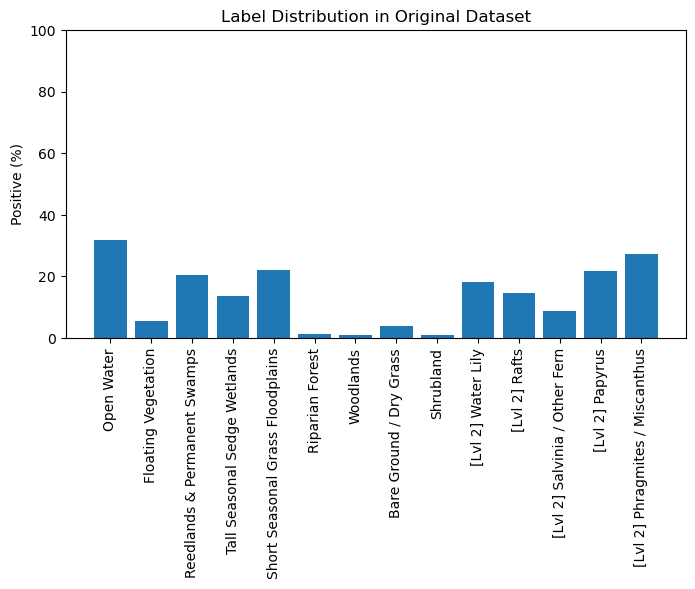


Label distribution in Train:
  Open Water: 31.66% positive
  Floating Vegetation: 5.40% positive
  Reedlands & Permanent Swamps: 20.40% positive
  Tall Seasonal Sedge Wetlands: 13.45% positive
  Short Seasonal Grass Floodplains: 22.05% positive
  Riparian Forest: 1.19% positive
  Woodlands: 1.10% positive
  Bare Ground / Dry Grass: 4.03% positive
  Shrubland: 1.10% positive
  [Lvl 2] Water Lily: 18.12% positive
  [Lvl 2] Rafts: 14.73% positive
  [Lvl 2] Salvinia / Other Fern: 8.69% positive
  [Lvl 2] Papyrus: 21.50% positive
  [Lvl 2] Phragmites / Miscanthus: 27.08% positive


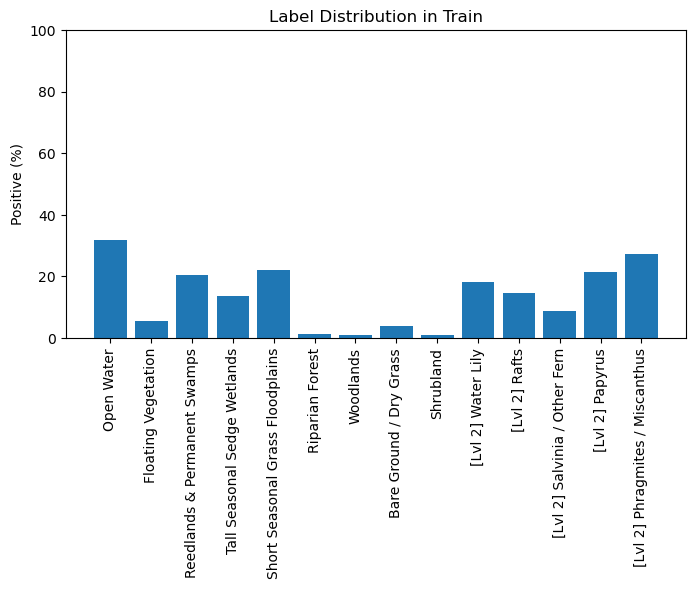


Label distribution in Validation:
  Open Water: 31.90% positive
  Floating Vegetation: 5.60% positive
  Reedlands & Permanent Swamps: 20.69% positive
  Tall Seasonal Sedge Wetlands: 13.79% positive
  Short Seasonal Grass Floodplains: 22.41% positive
  Riparian Forest: 1.29% positive
  Woodlands: 0.86% positive
  Bare Ground / Dry Grass: 3.88% positive
  Shrubland: 0.86% positive
  [Lvl 2] Water Lily: 18.10% positive
  [Lvl 2] Rafts: 14.66% positive
  [Lvl 2] Salvinia / Other Fern: 8.62% positive
  [Lvl 2] Papyrus: 21.98% positive
  [Lvl 2] Phragmites / Miscanthus: 27.16% positive


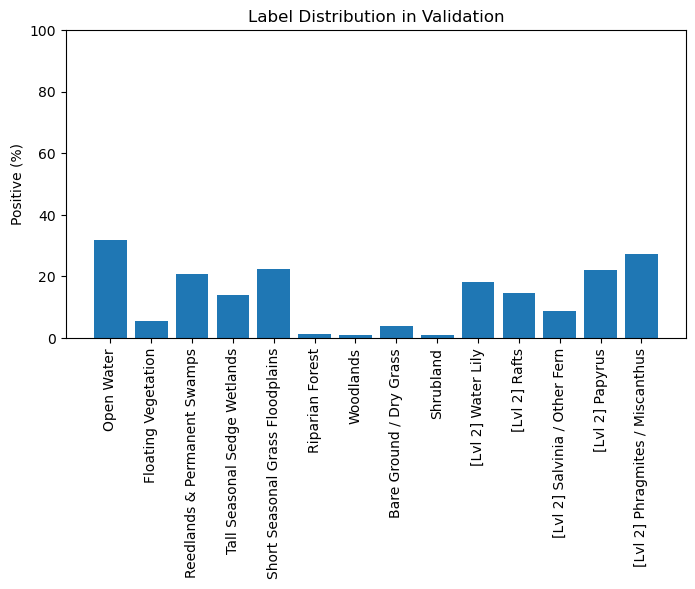


Label distribution in Test:
  Open Water: 31.76% positive
  Floating Vegetation: 5.58% positive
  Reedlands & Permanent Swamps: 20.60% positive
  Tall Seasonal Sedge Wetlands: 13.73% positive
  Short Seasonal Grass Floodplains: 22.32% positive
  Riparian Forest: 1.29% positive
  Woodlands: 1.29% positive
  Bare Ground / Dry Grass: 3.86% positive
  Shrubland: 0.86% positive
  [Lvl 2] Water Lily: 18.03% positive
  [Lvl 2] Rafts: 14.59% positive
  [Lvl 2] Salvinia / Other Fern: 8.58% positive
  [Lvl 2] Papyrus: 21.89% positive
  [Lvl 2] Phragmites / Miscanthus: 27.04% positive


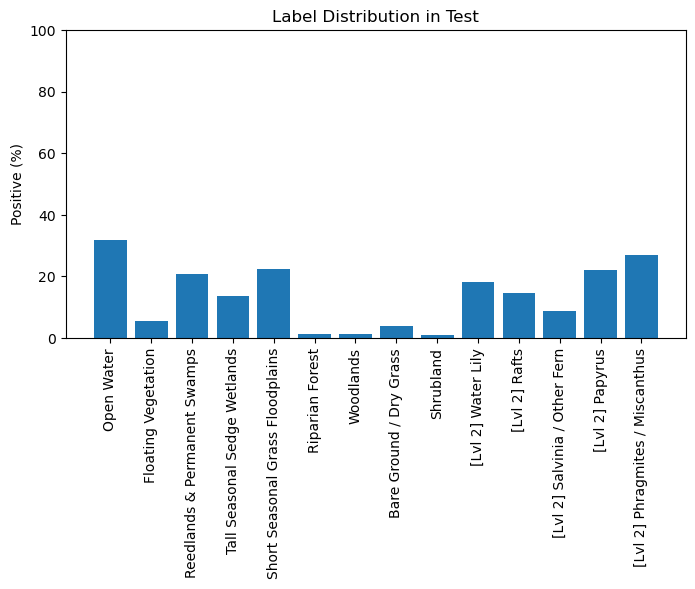

In [15]:
# Visualize the label distributions
show_label_distribution(df, label_columns, partition_name="Original Dataset")
show_label_distribution(df_train, label_columns, partition_name="Train")
show_label_distribution(df_val, label_columns, partition_name="Validation")
show_label_distribution(df_test, label_columns, partition_name="Test")